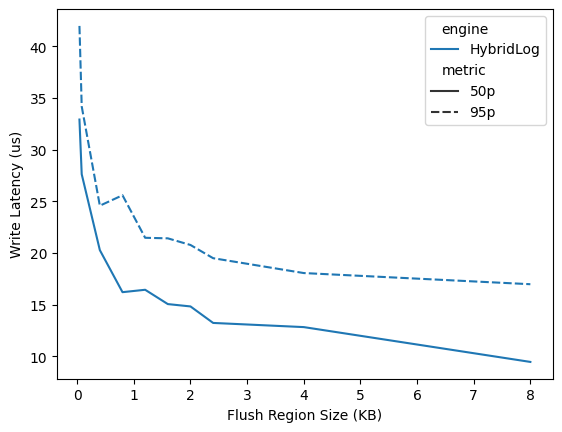


\begin{figure}[h]
    \centering
    \includegraphics[width=0.25\textwidth]{flush_interval_write.png}
    \caption{keylen: 4, vlen: 4, nitems: 10_000, writing 10Kkeys/sec, uniform distrib, max_runs_per_level: 3, mem_segment_len: 10K, ro_lag_interval: 1K, 10second sample for each average latency measurement}
    \label{fig:flush_interval_write.png}
\end{figure}



In [37]:
# writes

import sys
sys.path.append('..')
from utils import *
from distributions import Uniform, Zipfian, HotSet
from kevo import LSMTree, AppendLog, HybridLog, MemOnly, PathReplica


def measure_flush_interval(db, distro, keys_set, vals_set, n_ops, engine, eng_comb, **args):
    res = []

    seconds = 10
    writes_per_sec = 10_000

    latencies = []
    for i in range(seconds):
        # pick key/values to write
        with Timer() as latency:
            for _ in range(writes_per_sec):
                db[keys_set[next(distro)]] = vals_set[next(distro)]
        latency = float(latency)
        avg_latency = latency / writes_per_sec
        # if latency < 1:
        #     sleep(1 - latency)
        latencies.append(avg_latency)

    res.append({'metric': '50p', 'value': percentile(latencies, 50)})
    res.append({'metric': '95p', 'value': percentile(latencies, 95)})

    return res


df = run(
    [4], [4], [10_000], [0],
    [Uniform], [{'seed': [1]}],
    [HybridLog], [{
        'max_runs_per_level': [3],
        'mem_segment_len': [10_000],
        'ro_lag_interval': [1_000],
        'flush_interval': [5, 10, 50, 100, 150, 200, 250, 300, 500, 1000],
        'hash_index': ['dict'],
        'compaction_enabled': [False],
        'replica': [None]
    }],
    [measure_flush_interval], {}
)


data = df[['flush_interval', 'metric', 'value', 'engine']]
data = data[data['metric'].isin(['50p', '95p'])]
data['value'] = data['value'] * 1000000 # us
data['flush_interval'] = data['flush_interval'] * (4+4) / 1000

lineplot(data, 'flush_interval', 'value', 'flush_interval_write',
         hue='engine',
         style='metric',
         X='Flush Region Size (KB)', Y='Write Latency (us)',
         caption='keylen: 4, vlen: 4, nitems: 10_000, writing 10Kkeys/sec, uniform distrib, max_runs_per_level: 3, mem_segment_len: 10K, ro_lag_interval: 1K, 10second sample for each average latency measurement',
         save=True, show=True)


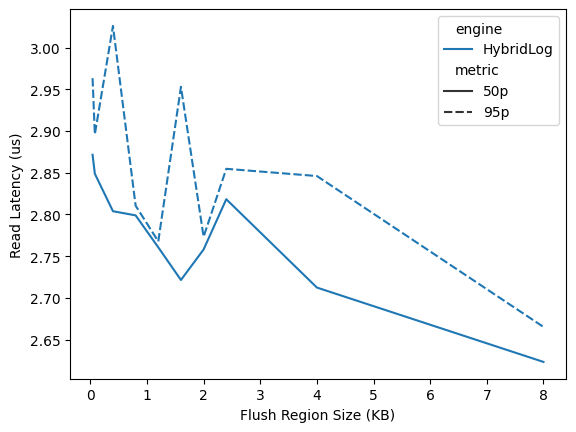


\begin{figure}[h]
    \centering
    \includegraphics[width=0.25\textwidth]{flush_interval_read.png}
    \caption{keylen: 4, vlen: 4, nitems: 10_000, reading 10Kkeys/sec, uniform distrib, max_runs_per_level: 3, mem_segment_len: 10K, ro_lag_interval: 1K, 10second sample for each average latency measurement}
    \label{fig:flush_interval_read.png}
\end{figure}



In [38]:
# reads


import sys
sys.path.append('..')
from utils import *
from distributions import Uniform, Zipfian, HotSet
from kevo import LSMTree, AppendLog, HybridLog, MemOnly, PathReplica


def measure_flush_interval(db, distro, keys_set, vals_set, n_ops, engine, eng_comb, **args):
    res = []

    seconds = 10
    reads_per_sec = 10_000
    
    # populate first
    for k, v in zip(keys_set, vals_set):
        db[k] = v

    latencies = []
    for i in range(seconds):
        # pick key/values to write
        with Timer() as latency:
            for _ in range(reads_per_sec):
                _ = db[keys_set[next(distro)]]
        latency = float(latency)
        avg_latency = latency / reads_per_sec
        # if latency < 1:
        #     sleep(1 - latency)
        latencies.append(avg_latency)

    res.append({'metric': '50p', 'value': percentile(latencies, 50)})
    res.append({'metric': '95p', 'value': percentile(latencies, 95)})

    return res


df = run(
    [4], [4], [10_000], [0],
    [Uniform], [{'seed': [1]}],
    [HybridLog], [{
        'max_runs_per_level': [3],
        'mem_segment_len': [10_000],
        'ro_lag_interval': [1_000],
        'flush_interval': [5, 10, 50, 100, 150, 200, 250, 300, 500, 1000],
        'hash_index': ['dict'],
        'compaction_enabled': [False],
        'replica': [None]
    }],
    [measure_flush_interval], {}
)


data = df[['flush_interval', 'metric', 'value', 'engine']]
data = data[data['metric'].isin(['50p', '95p'])]
data['value'] = data['value'] * 1000000 # us
data['flush_interval'] = data['flush_interval'] * (4+4) / 1000

lineplot(data, 'flush_interval', 'value', 'flush_interval_read',
         hue='engine',
         style='metric',
         X='Flush Region Size (KB)', Y='Read Latency (us)',
         caption='keylen: 4, vlen: 4, nitems: 10_000, reading 10Kkeys/sec, uniform distrib, max_runs_per_level: 3, mem_segment_len: 10K, ro_lag_interval: 1K, 10second sample for each average latency measurement',
         save=True, show=True)